In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from scipy.stats import tukey_hsd

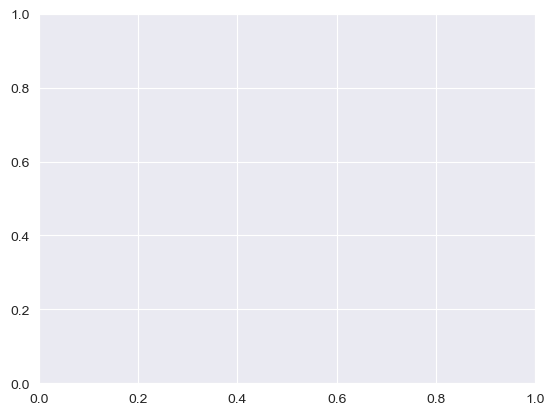

In [2]:
"""Modify base_path to point to the folder containing the scripts folder"""
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot, plot_avg_mean_fft


In [3]:
#Make paths
cwd = os.getcwd()
tmpdir = os.path.normpath(cwd + os.sep + os.pardir)
main_dir = os.path.normpath(tmpdir + os.sep + os.pardir)

print(main_dir)

C:\Users\xagao\OneDrive\Bureau\bio482_miniproject


In [4]:
"""Load data"""
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'python', 'figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'python/data') #if your folder is organized differently, just specify the full path to the file

fname = 'data_bio482-001.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: C:\Users\xagao\OneDrive\Bureau\bio482_miniproject


In [5]:
"""Create a subset of the data for the analysis of Free Whisking"""
sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

#data_df_subset = data_df[data_df["Sweep_Type"]==sweep_type]
#data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]
data_df_subset = data_df
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 240


In [6]:
data_df[data_df["Cell_Anatomy"]=='L5']

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
10,10.0,L5,1.0,550.0,SC903_1,L5,C2,EXC,False,NaN,...,1.0,"[-0.050484375, -0.050425, -0.05049375, -0.0505...",20000.0,"[6.461, 6.775]","[[0.002, 0.01], [6.226, 6.852], [9.71, 10.946]...",2005.0,active touch,"[11.55361080427187, 5.866629462925175, 0.06826...",100.0,"[[0.01, 5.386], [6.858, 9.516], [10.952, 11.68..."
39,10.0,L5,1.0,650.0,SC909_1,L5,C2,EXC,False,NaN,...,1.0,"[-0.065865625, -0.065815625, -0.06586875, -0.0...",20000.0,nan,"[[0.002, 0.47], [7.884, 8.814], [8.908, 10.046...",2006.0,active touch,"[-1.041554908752434, -1.2676734924316344, -1.2...",100.0,"[[0.52, 2.574], [3.138, 3.71], [4.8, 7.63], [1..."
40,10.0,L5,1.0,650.0,SC909_1,L5,C2,EXC,False,NaN,...,2.0,"[-0.062940625, -0.06293125, -0.062915625, -0.0...",20000.0,nan,"[[0.002, 0.01], [3.22, 3.998], [19.908, 20.0]]",2006.0,active touch,"[13.879621095657347, 28.42545607566833, 41.225...",100.0,"[[0.01, 1.164], [1.796, 2.322], [4.062, 10.69]..."
41,10.0,L5,1.0,650.0,SC909_1,L5,C2,EXC,False,NaN,...,3.0,"[-0.0594875, -0.059484375, -0.059453125, -0.05...",20000.0,nan,"[[0.002, 0.03], [2.76, 4.998], [5.418, 8.746],...",2006.0,active touch,"[0.3423306179046551, 0.731303472518915, 2.2265...",100.0,"[[0.036, 0.488], [1.684, 2.246], [5.052, 5.414..."


In [7]:
data_df.count()

Cell_APThreshold_Slope                  831
Cell_Anatomy                            831
Cell_Counter                            831
Cell_Depth                              814
Cell_ID                                 831
Cell_Layer                              831
Cell_TargetedBrainArea                  831
Cell_Type                               831
Cell_tdTomatoExpressing                 831
Mouse_DateOfBirth                       602
Mouse_Genotype                          831
Mouse_Name                              831
Mouse_Sex                               831
Sweep_ActiveContactTimes                831
Sweep_Counter                           831
Sweep_MembranePotential                 831
Sweep_MembranePotential_SamplingRate    831
Sweep_PassiveContactTimes               831
Sweep_QuietTimes                        830
Sweep_StartTime                         831
Sweep_Type                              831
Sweep_WhiskerAngle                      831
Sweep_WhiskerAngle_SamplingRate 

In [8]:
data_df.groupby('Cell_Anatomy').describe()

Cell_APThreshold_Slope                                         \
                              count       mean       std   min   25%   50%   
Cell_Anatomy                                                                 
L2/3                          218.0  11.743119  5.509780  10.0  10.0  10.0   
L4                            128.0  17.734375  7.446909   0.0  10.0  15.0   
L5                              4.0  10.000000  0.000000  10.0  10.0  10.0   
nan                           481.0  16.361746  6.964651   0.0  10.0  15.0   

                         Cell_Counter            ... Sweep_StartTime          \
               75%   max        count      mean  ...             75%     max   
Cell_Anatomy                                     ...                           
L2/3          10.0  40.0        218.0  1.137615  ...          2009.0  2016.0   
L4            20.0  35.0        128.0  1.804688  ...          2016.0  2017.0   
L5            10.0  10.0          4.0  1.000000  ...          2006.0  2006.0   
nan           20.0  35.0        481.0  1.501040  ...          2015.0  2016.0   

             Sweep_WhiskerAngle_SamplingRate                                   \
                                       count   mean  std    min    25%    50%   
Cell_Anatomy                                                                    
L2/3                                   218.0  100.0  0.0  100.0  100.0  100.0   
L4                                     128.0  100.0  0.0  100.0  100.0  100.0   
L5                                       4.0  100.0  0.0  100.0  100.0  100.0   
nan                                    481.0  100.0  0.0  100.0  100.0  100.0   

                            
                75%    max  
Cell_Anatomy                
L2/3          100.0  100.0  
L4            100.0  100.0  
L5            100.0  100.0  
nan           100.0  100.0  

[4 rows x 64 columns]

In [9]:
data_df[data_df['Cell_Depth'].isna()]

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
695,25.0,nan,2.0,NaN,AP032_2,L2/3,C2,PV,True,2015.0,...,1.0,"[-0.043900002, -0.043940626, -0.043962501, -0....",20000.0,nan,"[[0.002, 0.6], [4.856, 6.658], [7.136, 10.626]...",2015.0,free whisking,"[-137.0508, -137.0508, -137.6991, -137.6991, -...",100.0,"[[0.604, 1.634], [2.092, 4.786], [6.782, 7.132..."
723,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,1.0,"[-0.053934377, -0.053981248, -0.054043751, -0....",20000.0,nan,"[[0.002, 1.606], [1.668, 5.258], [6.57, 7.4], ...",2015.0,free whisking,"[-141.6704, -139.2687, -139.8691, -141.07, -14...",100.0,"[7.404, 8.47]"
724,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,2.0,"[-0.058571875, -0.058571875, -0.058546875, -0....",20000.0,nan,"[[0.002, 2.21], [2.248, 2.824], [5.984, 8.458]...",2015.0,free whisking,"[-145.8735, -145.8735, -145.8735, -145.8735, -...",100.0,"[2.848, 5.97]"
725,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,3.0,"[-0.055190627, -0.055275001, -0.055356249, -0....",20000.0,nan,"[[0.002, 2.344], [2.362, 7.72], [7.744, 9.836]...",2015.0,free whisking,"[-147.0743, -147.0743, -147.0743, -147.0743, -...",100.0,"[[12.756, 15.276], [15.682, 15.922], [18.798, ..."
726,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,4.0,"[-0.045990624, -0.045896877, -0.045850001, -0....",20000.0,nan,"[[0.002, 0.01], [0.536, 1.398], [2.89, 3.616],...",2015.0,free whisking,"[-160.284, -157.2818, -156.6813, -157.8822, -1...",100.0,"[[0.036, 0.46], [1.58, 2.846], [3.62, 3.97], [..."
727,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,5.0,"[-0.050637498, -0.050656252, -0.05064375, -0.0...",20000.0,nan,"[[0.002, 4.146], [6.93, 9.222], [9.434, 13.402...",2015.0,free whisking,"[-145.273, -145.273, -145.273, -145.273, -145....",100.0,"[[4.154, 5.128], [5.564, 6.578], [13.404, 13.9..."
728,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,6.0,"[-0.056031249, -0.056121875, -0.056181248, -0....",20000.0,nan,"[[0.002, 0.29], [1.388, 2.37], [2.888, 5.718],...",2015.0,free whisking,"[-147.0743, -147.0743, -147.6748, -148.8757, -...",100.0,"[[0.46, 1.384], [2.396, 2.748], [5.726, 5.98],..."
729,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,7.0,"[-0.04756875, -0.047512501, -0.047474999, -0.0...",20000.0,nan,"[[0.002, 0.694], [1.636, 8.086], [8.136, 9.144...",2015.0,free whisking,"[-150.677, -150.0765, -150.677, -150.677, -150...",100.0,"[0.698, 1.63]"
730,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,8.0,"[-0.051750001, -0.051778127, -0.051750001, -0....",20000.0,nan,"[[0.002, 1.256], [1.384, 2.148], [2.826, 3.916...",2015.0,free whisking,"[-146.4739, -145.8735, -146.4739, -146.4739, -...",100.0,"[[2.176, 2.824], [5.158, 5.564], [6.774, 7.142..."
731,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,9.0,"[-0.051190626, -0.051240627, -0.051278125, -0....",20000.0,nan,"[[0.002, 0.17], [0.296, 4.616], [4.714, 6.27],...",2015.0,free whisking,"[-142.2708, -142.2708, -142.8713, -142.8713, -...",100.0,"[[6.38, 9.19], [19.664, 19.986]]"


In [10]:
#L2-L3, 250 μm; L3-L4, 400 μm; L4-L5, 600 μm
def define_layer(cell_depth):
    if cell_depth <= 250:
        return 'L2'
    elif 250 < cell_depth <= 400:
        return 'L3'
    elif 400 < cell_depth <= 600:
        return 'L4'
    elif cell_depth > 600:
        return 'L5'
    else:
        return str(cell_depth)
    
data_df[data_df["Cell_Anatomy"]=='nan']["Cell_Depth"].apply(lambda x: define_layer(x)).unique()

array(['L3', 'L4', 'L5', 'L2', 'nan'], dtype=object)

In [11]:
data_df["Sweep_Type"].unique()

array(['active touch', 'passive contact', 'free whisking'], dtype=object)

In [12]:
data_df[data_df["Sweep_Type"] == "passive contact"]

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]"
89,10.0,L2/3,1.0,150.0,SC916_1,L2/3,C2,EXC,False,NaN,...,11.0,"[-0.074971875, -0.07498125, -0.074975, -0.0749...",20000.0,"[[3.218999999999994, 3.233000000000004], [6.12...","[[0.002, 3.242], [8.288, 9.068], [9.64, 11.438...",2006.0,passive contact,"[-3.8482535171508845, -0.7891242027282714, -0....",100.0,"[3.324, 8.02]"
142,10.0,L2/3,1.0,170.0,SC925_1,L2/3,C2,EXC,False,NaN,...,13.0,"[-0.05756875, -0.0575625, -0.05755625, -0.0575...",20000.0,"[[3.61099999999999, 3.959000000000003], [4.949...","[[0.002, 0.224], [5.382, 6.074], [7.382, 7.998...",2007.0,passive contact,"[-1.7824999999999989, -2.145000000000003, -2.9...",100.0,"[[0.754, 1.132], [2.662, 3.232], [4.964, 5.274..."


In [13]:
data_df["Layer"] = data_df["Cell_Depth"].apply(lambda x: define_layer(x))
#data_df[data_df["Layer"]=="nan"]["Layer"] = data_df[data_df["Layer"]=="nan"]["Cell_Layer"]

data_df.loc[data_df["Layer"]=="nan", "Layer"] = data_df.loc[data_df["Layer"]=="nan", "Cell_Layer"]
data_df["Layer"].count()

831

In [14]:
"""Assert that all trials for a given cell have the same depth and layer"""
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for cell in cell_list:
    depth = data_df_subset[data_df_subset.Cell_ID==cell].Cell_Depth.values[0]
    layer = data_df_subset[data_df_subset.Cell_ID==cell].Cell_Anatomy.values[0]
    for dpeth in data_df_subset[data_df_subset.Cell_ID==cell].Cell_Depth:
        assert (depth == dpeth or np.isnan(depth)), 'Cell depth is not the same for all trials for cell {}'.format(cell)
    for layer1 in data_df_subset[data_df_subset.Cell_ID==cell].Cell_Anatomy:
        assert (layer1 == layer or np.isnan(layer1)), 'Cell layer is not the same for all trials for cell {}'.format(cell)    

In [44]:
"""Create a dictionary to store data for all cells"""
verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = { "free whisking": 
                    {'cell_id': [],
                    'cell_layer': [],
                    'cell_layer2': [],
                    'cell_depth' : [],
                    'cell_type':[], # required for cell-type identification
                    # Data we'll collect for Part 1a
                    'firing_rate': [],
                    'ap_threshold': [],
                    'ap_duration': [],
                    # Data we'll collect for Part 1b
                    'mean_vm':[],
                    'std_vm':[],
                    'fft_low':[],
                    'fft_high':[]},
                
                "active touch":
                    {'cell_id': [],
                     'cell_layer': [],
                     'cell_layer2': [],
                     'cell_depth' : [],
                     'cell_type':[], # required for cell-type identification
                     # Data we'll collect for Part 1a
                     'firing_rate': [],
                     'ap_threshold': [],
                     'ap_duration': [],
                     # Data we'll collect for Part 1b
                     'mean_vm':[],
                     'std_vm':[],
                     'fft_low':[],
                     'fft_high':[]
                     }}

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[], 'L3':[], 'L4':[], 'L2':[],'L5':[], 'L2/3': []}
result_fft = {  "free whisking": {
                    'L3':[], 'L4':[], 'L2':[],'L5':[], 'L2/3': []
                },
                "active touch": {
                    'L3':[], 'L4':[], 'L2':[],'L5':[], 'L2/3': []
                }
                }

exc_cell_counter = 0

In [45]:
for key in result_dict.keys():
    data_df_subset = data_df[data_df["Sweep_Type"]==key]
    all_cells = np.unique(data_df_subset.Cell_ID)
    result_dict[key]['cell_id'] = all_cells
    cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
    # Iterate over each cell identities to collect desired data
    for idx, cell in enumerate(tqdm(cell_list, desc='Processing Cells')):
    
        # Get mouse name and cell number from cell identifier
        mouse = cell.split('_')[0]
        cell_count = float(cell.split('_')[1])
    
        # Get data subset for that cell
        cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
        # Get cell type 
        cell_type = cell_df.Cell_Type.values[0]
        result_dict[key]['cell_type'] += [cell_type]
        result_dict[key]['cell_depth'] += [cell_df.Cell_Depth.values[0]]
        result_dict[key]['cell_layer'] += [cell_df.Cell_Anatomy.values[0]]
        result_dict[key]['cell_layer2'] += [cell_df.Layer.values[0]]
    
        # Get sweeps/trials recorded for that cell, that we are going to iterate over
        trial_list = cell_df.Sweep_Counter.values
    
        # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
        tot_rec_duration = 0
        tot_number_ap = 0
    
        # Initialize empty lists to get data for each trial/sweep
        # Part 1a
        tot_ap_thresh = []
        tot_ap_duration = []
        # Part 1b
        tot_mean_vm = []
        tot_std_vm = []
        tot_fft = []
    
        # For that cell, iterate over trials
        for trial in trial_list:
            #if idx % 100 == 0: # print every 100 iteration  
            #print('Cell {},  trial {}'.format(cell, int(trial)))
            if cell_type == 'EXC':
                exc_cell_counter += 1
    
            # Get current trial data
            cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
    
            # Get the sampling rate and membrane potential (and derivative) from that sweep
            sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
            membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
            ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
    
            # Get and update recording duration for that cell by adding trial duration
            trial_rec_duration = len(membrane_potential)/sr_vm
            tot_rec_duration += trial_rec_duration
    
            # Detection of action potentials for that trial, and update total number of APs for that cell
            #ap_params = None
            ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
            tot_number_ap += ap_params.shape[0]
    
            # Check if this trial contains any AP...
            ap_duration = []
            if (ap_params.any()):
                ap_thresh_times = ap_params[:,0]
                ap_thresh_vm = ap_params[:,1]
                ap_peak_times = ap_params[:,2]
                ap_peak_vm = ap_params[:,3]
                ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
    
                #... if so, cut-out individual APs to keep subthreshold Vm only
                vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
    
    
            # Else if no AP, subthreshold Vm is just Vm
            else:
    
                vm_sub = membrane_potential.copy()
    
            # Once Vm_sub is obtained:
            # Compute subthreshold Vm mean and standard deviation
            mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)
    
            # Compute trial FFT
            fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)
    
            #Update current variables from the current trial
            # Part 1a
            tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
            tot_ap_duration += [ap_duration]
            # Part 1b
            tot_mean_vm += [mean_vm]
            tot_std_vm += [std_vm]
            tot_fft +=  [fft]
    
            # Optional plotting: show AP and AP peak times
            ap_peak_index=np.round(ap_peak_times * sr_vm)
            if verbose:
                fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
                remove_top_right_frame(ax)
                ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
                ax.plot(membrane_potential, lw=0.5,  zorder=0)
                ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
                ax.set_xlabel('Time (samples)')
                ax.set_ylabel('Membrane \n potential (V)')
                plt.show()
    
        # Once iterated over all trials for that cell, append cell data lists to the result dictionary
    
        # Part 1a
        result_dict[key]['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
        result_dict[key]['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
        result_dict[key]['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]
    
    
        # Part 1b
        result_dict[key]['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
        result_dict[key]['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]
    
        # Compute mean FFT over trials
        tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
        #Store mean cell FFT
        result_fft_cell_type[cell_type] += [tot_fft]
        result_fft_cell_type[cell_df.Layer.values[0]] += [tot_fft]
        result_fft[key][cell_df.Layer.values[0]] += [tot_fft]
    
        # We need to find which point (sample) in the FFT correspond to which frequency
        pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
        pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
        result_dict[key]['fft_low'] += [tot_fft[pt1:pt2].mean()]
    
        pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
        pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1
        result_dict[key]['fft_high'] += [tot_fft[pt3:pt4].mean()]
    
    ## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
    result_dict[key] = {key1: np.array(result_dict[key][key1]) for key1 in result_dict[key].keys()}
    
    print('Done! for %s' %key)
    
print('Done! for all')    

Processing Cells:  45%|████▌     | 105/232 [02:16<01:01,  2.06it/s]C:\Users\xagao\OneDrive\Bureau\bio482_miniproject\python\scripts\helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))
Processing Cells:  80%|███████▉  | 185/232 [04:06<00:34,  1.37it/s]C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\1468984220.py:114: RuntimeWarning: Mean of empty slice
  result_dict[key]['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]
Processing Cells:  87%|████████▋ | 201/232 [04:08<00:07,  4.29it/s]C:\Users\xagao\OneDrive\Bureau\bio482_miniproject\python\scripts\helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
Processing Cells: 100%|██████████| 232/232 [05:33<00:00,  1.44s/it]


Done! for free whisking


Processing Cells: 100%|██████████| 134/134 [05:14<00:00,  2.35s/it]

Done! for active touch
Done! for all


In [46]:
saved_dict_path = 'all_cells.pickle'

if os.path.isfile(saved_dict_path):
    with open(saved_dict_path, 'rb') as handle:
        result_dict = pickle.load(handle)
else:
    with open(saved_dict_path, 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

saved_fft_path = 'all_cells_fft.pickle'

if os.path.isfile(saved_fft_path):
    with open(saved_fft_path, 'rb') as handle:
        result_fft_cell_type = pickle.load(handle)
else:
    with open(saved_fft_path, 'wb') as handle:
        pickle.dump(result_fft_cell_type, handle, protocol=pickle.HIGHEST_PROTOCOL)


saved_fft_path_spec = 'cells_fft.pickle'

if os.path.isfile(saved_fft_path_spec):
    with open(saved_fft_path_spec, 'rb') as handle:
        result_fft = pickle.load(handle)
else:
    with open(saved_fft_path_spec, 'wb') as handle:
        pickle.dump(result_fft, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
result_dict_df = {
    "free whisking": pd.DataFrame(result_dict["free whisking"]),
    "active touch": pd.DataFrame(result_dict["active touch"])
}

In [48]:
result_dict_df.keys()

dict_keys(['free whisking', 'active touch'])

In [49]:
layer_df = result_dict_df["free whisking"].groupby('cell_layer2').describe()
result_df = result_dict_df["free whisking"]
layer_df

cell_depth                                                      \
                 count        mean        std    min     25%    50%    75%   
cell_layer2                                                                  
L2                95.0  179.442105  42.517260   97.0  146.50  180.0  215.5   
L2/3               0.0         NaN        NaN    NaN     NaN    NaN    NaN   
L3                42.0  339.238095  41.641800  256.0  307.25  341.0  374.0   
L4                87.0  474.758621  46.485048  403.0  439.50  463.0  500.0   
L5                 6.0  628.166667  25.182666  601.0  609.25  623.0  645.0   

                   firing_rate             ...   fft_low           fft_high  \
               max       count       mean  ...       75%       max    count   
cell_layer2                                ...                                
L2           250.0        95.0  11.123659  ...  0.000831  0.001389     95.0   
L2/3           NaN         2.0  30.664062  ...  0.000836  0.000896      2.0   
L3           400.0        42.0   5.940829  ...  0.000752  0.001145     42.0   
L4           586.0        87.0  11.374343  ...  0.000732  0.001063     87.0   
L5           665.0         6.0   5.071759  ...  0.000803  0.000975      6.0   

                                                                         \
                 mean       std       min       25%       50%       75%   
cell_layer2                                                               
L2           0.000059  0.000025  0.000020  0.000041  0.000049  0.000079   
L2/3         0.000097  0.000011  0.000089  0.000093  0.000097  0.000101   
L3           0.000065  0.000018  0.000028  0.000055  0.000063  0.000075   
L4           0.000065  0.000023  0.000031  0.000047  0.000060  0.000077   
L5           0.000045  0.000019  0.000019  0.000038  0.000044  0.000050   

                       
                  max  
cell_layer2            
L2           0.000119  
L2/3         0.000104  
L3           0.000107  
L4           0.000130  
L5           0.000076  

[5 rows x 64 columns]

In [50]:
cell_type_df = result_df.groupby('cell_type').describe()
cell_type_df

cell_depth                                                        \
               count        mean         std    min     25%    50%     75%   
cell_type                                                                    
EXC             86.0  378.069767  143.943844  120.0  250.00  393.5  472.25   
PV              47.0  334.787234  127.489290  158.0  214.50  338.0  458.00   
SST             72.0  323.291667  135.045161   97.0  198.25  347.5  444.75   
VIP             25.0  193.680000  140.274350   98.0  125.00  147.0  175.00   

                 firing_rate             ...   fft_low           fft_high  \
             max       count       mean  ...       75%       max    count   
cell_type                                ...                                
EXC        665.0        86.0   1.822975  ...  0.000782  0.001091     86.0   
PV         547.0        49.0  29.343396  ...  0.000948  0.001389     49.0   
SST        550.0        72.0   6.597538  ...  0.000540  0.000926     72.0   
VIP        571.0        25.0  12.718557  ...  0.000785  0.001063     25.0   

                                                                       \
               mean       std       min       25%       50%       75%   
cell_type                                                               
EXC        0.000054  0.000018  0.000019  0.000042  0.000052  0.000065   
PV         0.000093  0.000017  0.000043  0.000082  0.000095  0.000104   
SST        0.000056  0.000017  0.000028  0.000043  0.000051  0.000068   
VIP        0.000054  0.000020  0.000020  0.000044  0.000050  0.000068   

                     
                max  
cell_type            
EXC        0.000096  
PV         0.000130  
SST        0.000102  
VIP        0.000105  

[4 rows x 64 columns]

In [51]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'}
cell_class_order = ['EXC', 'PV', 'VIP', 'SST']

result_df.dropna(inplace=True, subset=['cell_depth'])

In [52]:
Obs_EXC = result_df[result_df.cell_type=='EXC']['cell_depth'].values
Obs_PV = result_df[result_df.cell_type=='PV']['cell_depth'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['cell_depth'].values
Obs_SST = result_df[result_df.cell_type=='SST']['cell_depth'].values

Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     43.283     0.308   -21.297   107.862
 (0 - 2)    184.390     0.000   103.497   265.282
 (0 - 3)     54.778     0.064    -2.091   111.648
 (1 - 0)    -43.283     0.308  -107.862    21.297
 (1 - 2)    141.107     0.000    52.979   229.235
 (1 - 3)     11.496     0.970   -55.266    78.257
 (2 - 0)   -184.390     0.000  -265.282  -103.497
 (2 - 1)   -141.107     0.000  -229.235   -52.979
 (2 - 3)   -129.612     0.000  -212.257   -46.967
 (3 - 0)    -54.778     0.064  -111.648     2.091
 (3 - 1)    -11.496     0.970   -78.257    55.266
 (3 - 2)    129.612     0.000    46.967   212.257



C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: xlabel='cell_type', ylabel='cell_depth'>

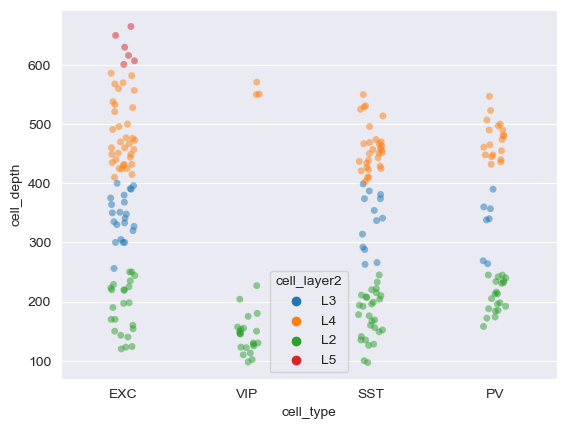

In [53]:
sns.stripplot(data=result_df, x="cell_type", y="cell_depth", jitter=True, alpha=0.5, hue='cell_layer2')

C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: xlabel='cell_layer2', ylabel='cell_depth'>

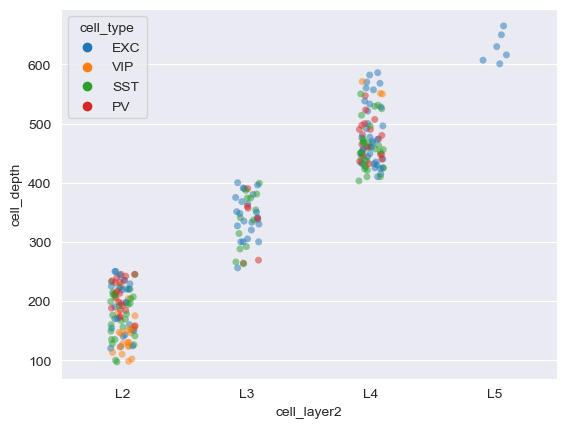

In [54]:
sns.stripplot(data=result_df, x="cell_layer2", y="cell_depth", jitter=True, alpha=0.5, hue="cell_type", order=['L2', 'L3', 'L4', 'L5'])

In [72]:
def plot1(result_dict_df, column):
    for key in result_dict_df:
        result_df = result_dict_df[key]
        fig, axs = plt.subplots(1,len(result_df.cell_layer2.unique()), sharey=True, figsize=(16,4), dpi=100)
    
        for i,layer in enumerate(result_df.cell_layer2.unique()):
            ax = axs[i]
            l2 = result_df[result_df.cell_layer2==layer]
            # Define figure
            remove_top_right_frame(ax)
    
            # Iterate over cell class
            for i, c_type in enumerate(cell_class_order):
    
                n_cells = len(l2[l2.cell_type==c_type])
                obs_locations = [i]*n_cells #create a list int, to place observations categorically
                obs_values = l2[l2.cell_type==c_type][column].values * 1000 #in mV
    
                # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
                jitter_scatterplot(x=obs_locations,
                                   y=obs_values,
                                   s=3,
                                   alpha=0.5,
                                   c=class_color[c_type],
                                   ax=ax)
    
                # Show mean and standard deviation
                ax.errorbar(x=i+0.2,
                            y=np.nanmean(obs_values),
                            yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                            marker='o',
                            ms=10,
                            capsize=5,
                            alpha=0.9,
                            c=class_color[c_type])
    
            # Set xtick labels and legend
            ax.set_xticks([0,1,2,3])
            ax.set_xticklabels(cell_class_order)
            ax.set_xlabel('Cell class')
            ax.set_ylabel('Membrane potential, Vm (mV)')
            ax.set_title('%s - %s - %s' %(column, key,layer))
        plt.show()
        
def plot2(result_dict_df, column):
    for key in result_dict_df:
        result_df = result_dict_df[key]
        fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), dpi=100)
    
        for i, c_type in enumerate(cell_class_order):
            ax = axs[i]
            cells = result_df[result_df.cell_type==c_type]
            remove_top_right_frame(ax)
    
            for j, layer in enumerate(result_df.cell_layer2.unique()):
                observed = cells[cells.cell_layer2==layer]
                n_cells = len(observed)
                obs_locations = [j]*n_cells #create a list int, to place observations categorically
                obs_values = observed['mean_vm'].values * 1000 #in mV
                # Iterate over cell class
    
                # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
                jitter_scatterplot(x=obs_locations,
                                   y=obs_values,
                                   s=3,
                                   alpha=0.5,
                                   label=layer,
                                   ax=ax)
    
                # Show mean and standard deviation
                ax.errorbar(x=j+0.2,
                            y=np.nanmean(obs_values),
                            yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                            marker='o',
                            ms=10,
                            capsize=5,
                            alpha=0.9,
                            label=layer)
    
    
            # Set xtick labels and legend
            ax.set_xticks([0,1,2,3])
            ax.set_xticklabels(result_df.cell_layer2.unique())
            ax.set_xlabel('Cell class')
            ax.set_ylabel('%s' %column)
            ax.set_title('%s - %s - %s' %(column,key,c_type))
        plt.show()

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


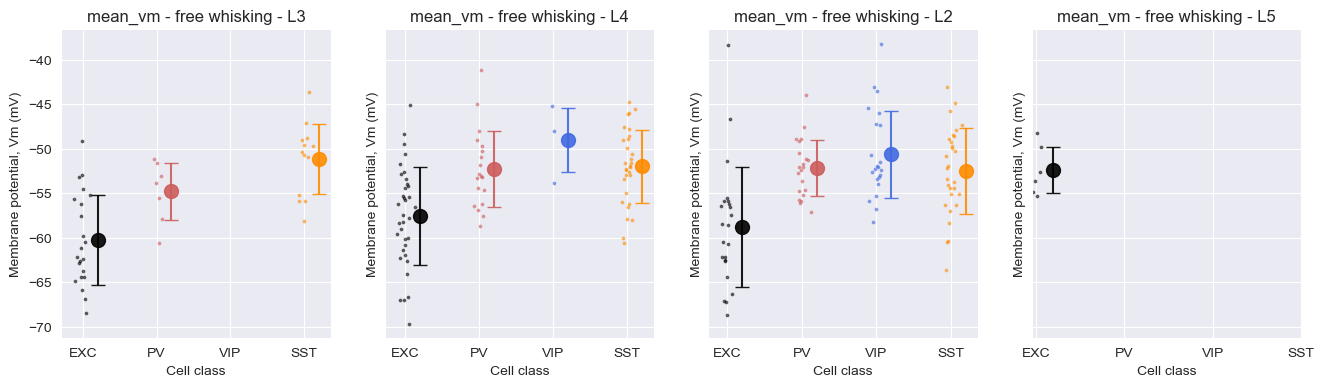

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


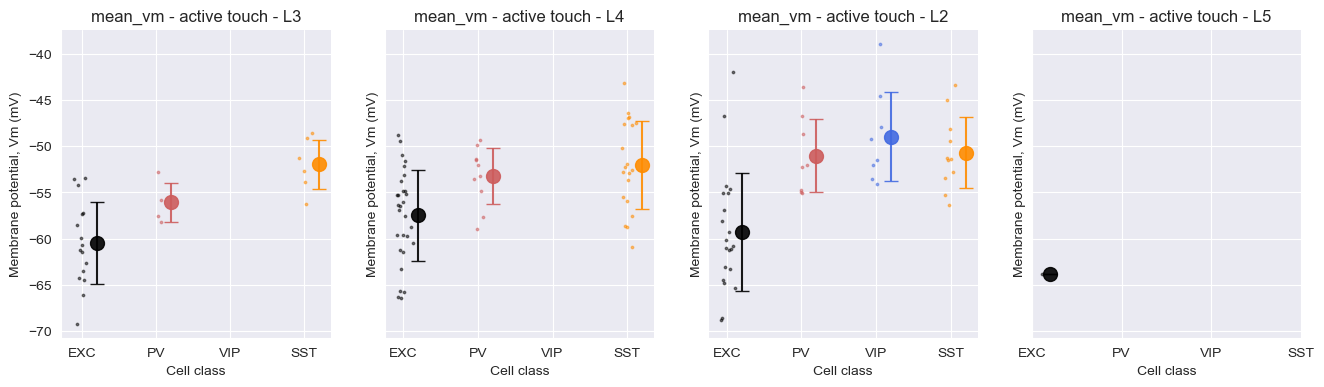

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


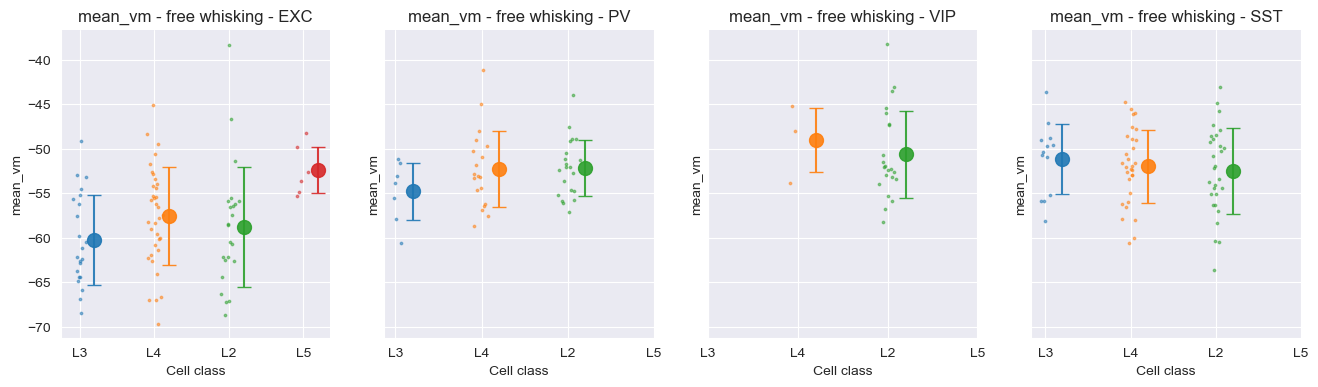

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


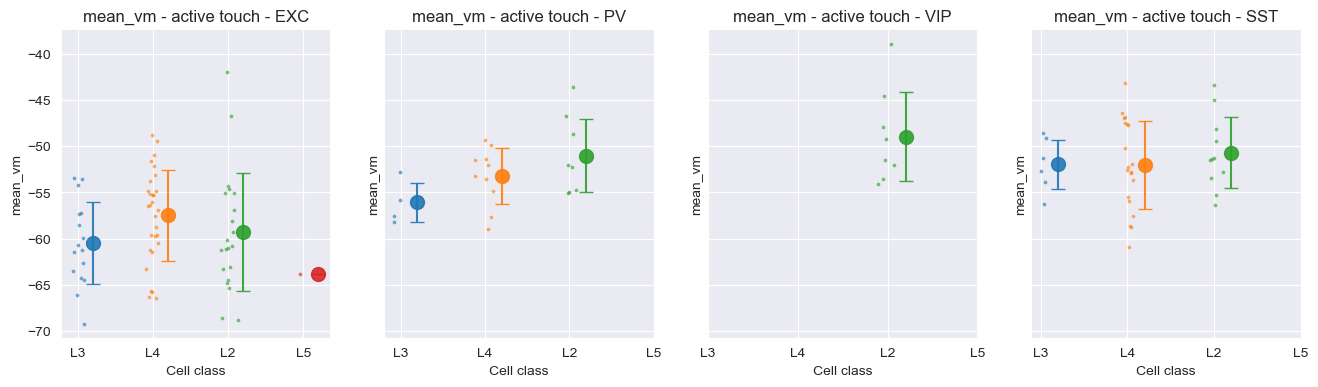

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


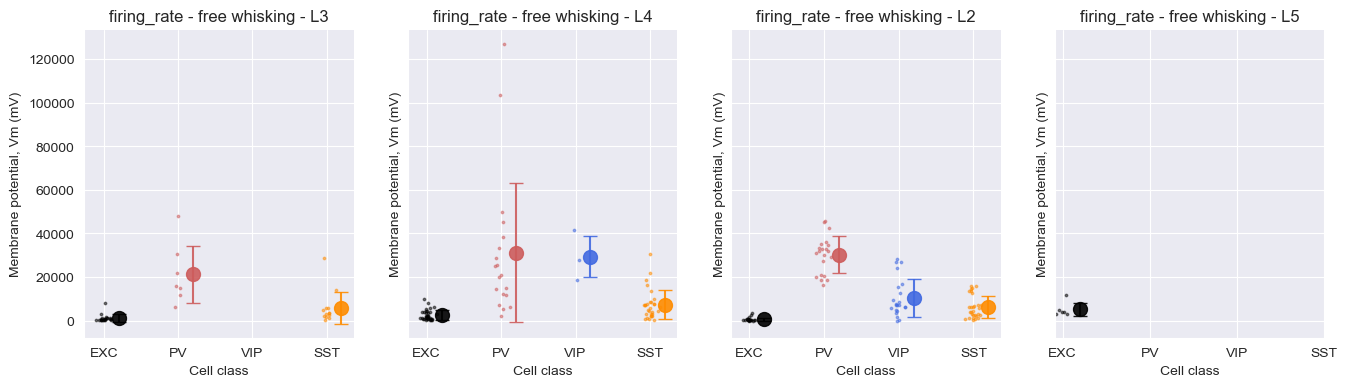

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


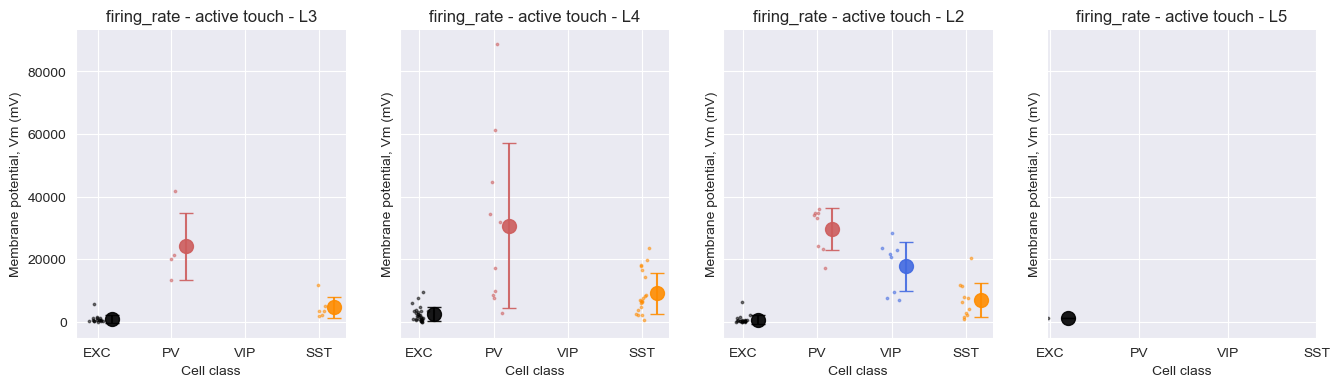

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


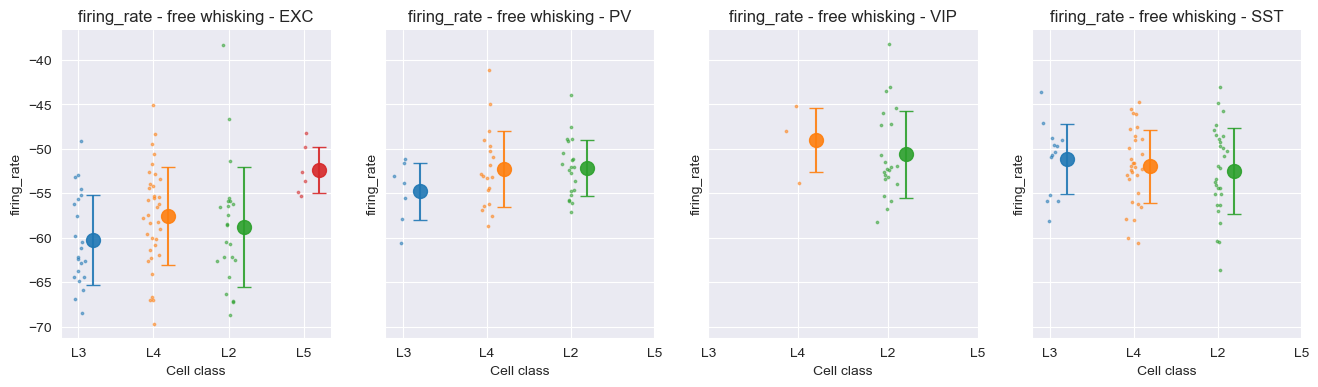

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


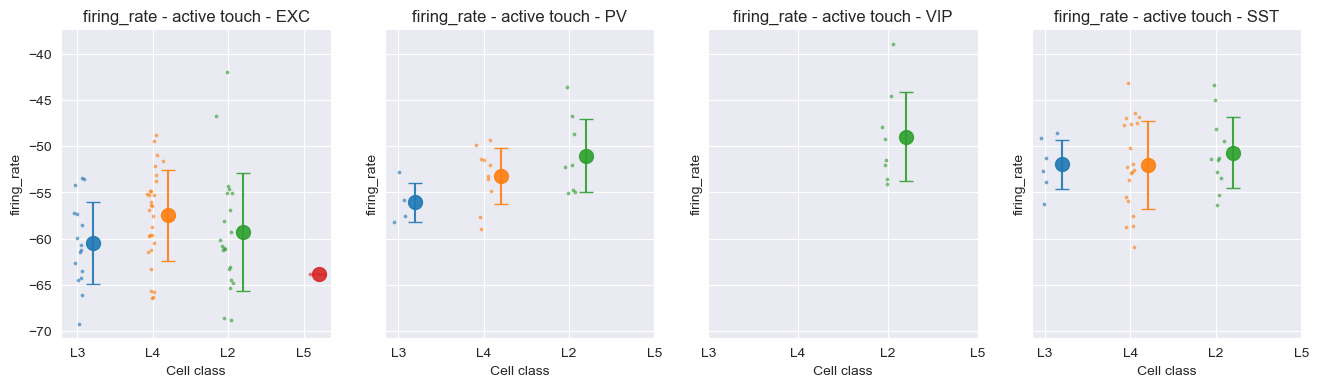

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


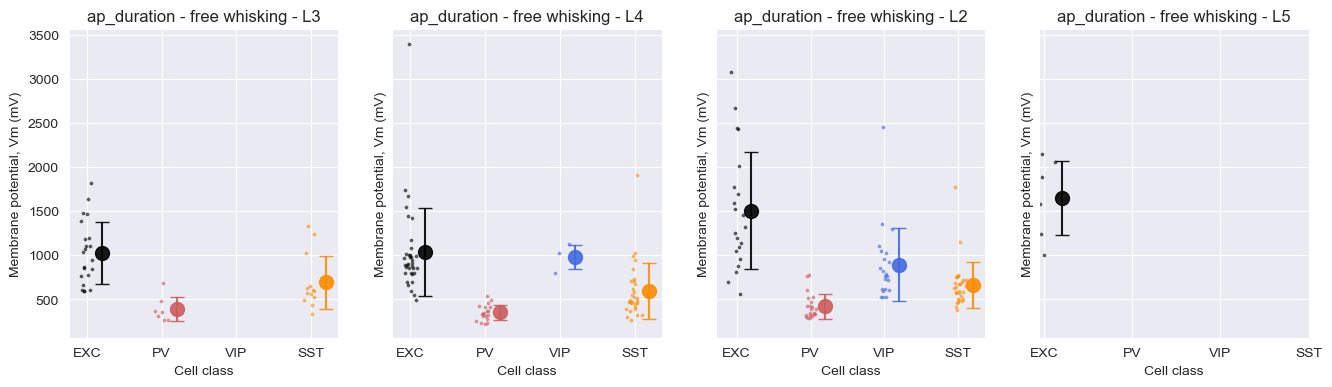

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


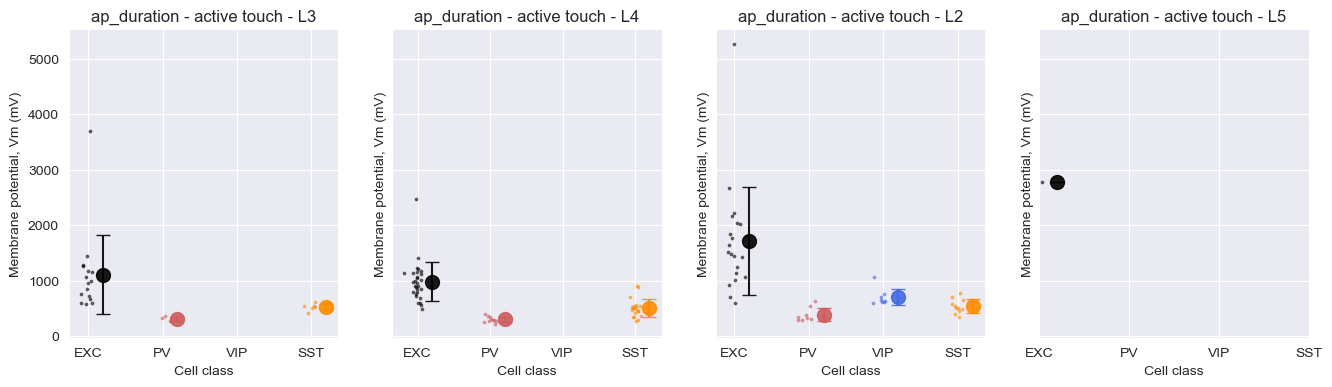

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


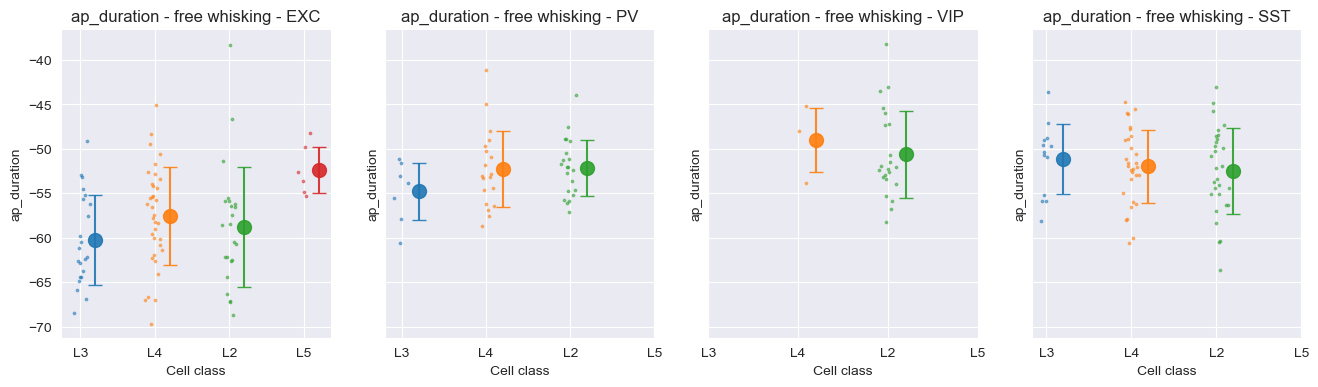

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


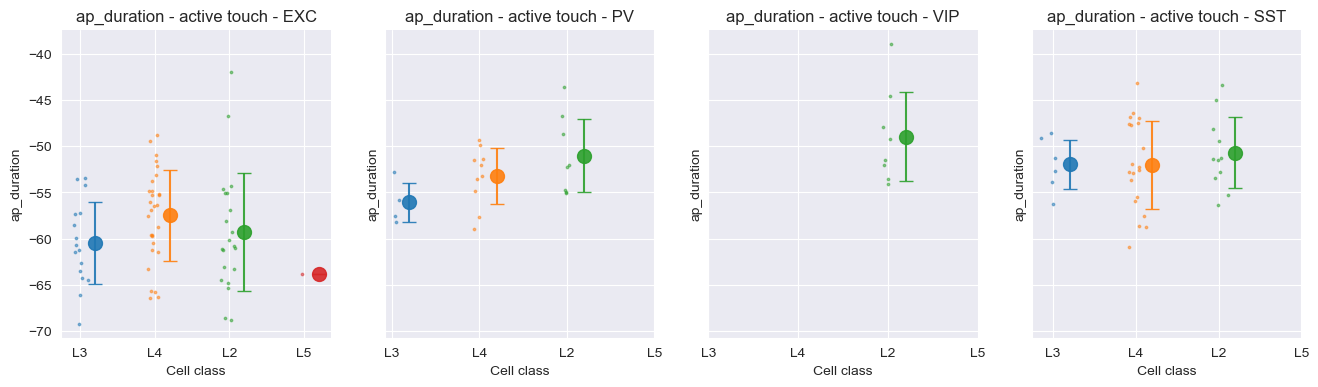

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


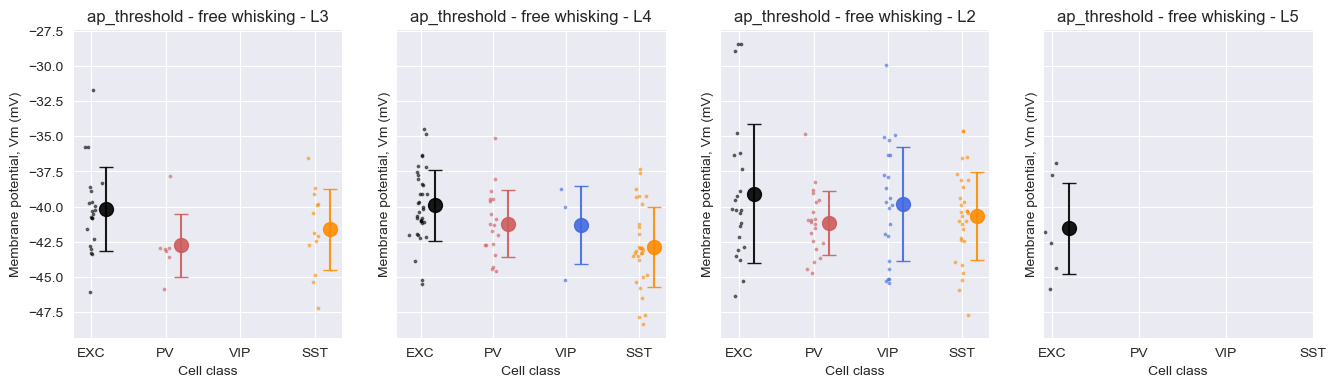

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:29: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


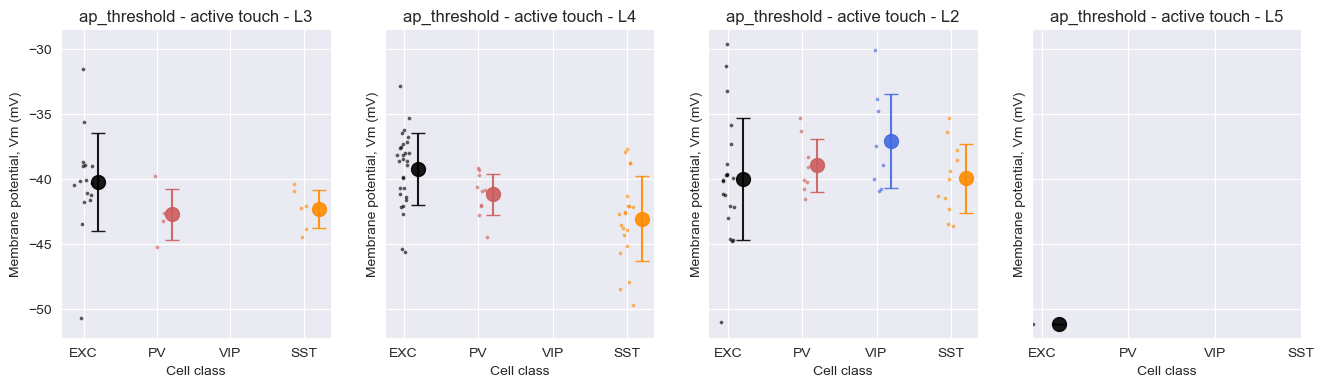

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


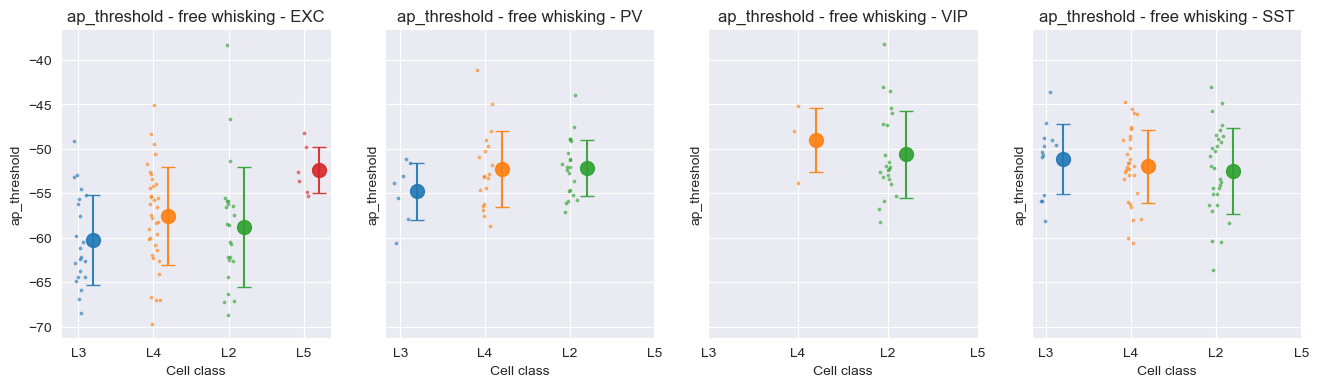

C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xagao\AppData\Local\Temp\ipykernel_71788\3054753558.py:72: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


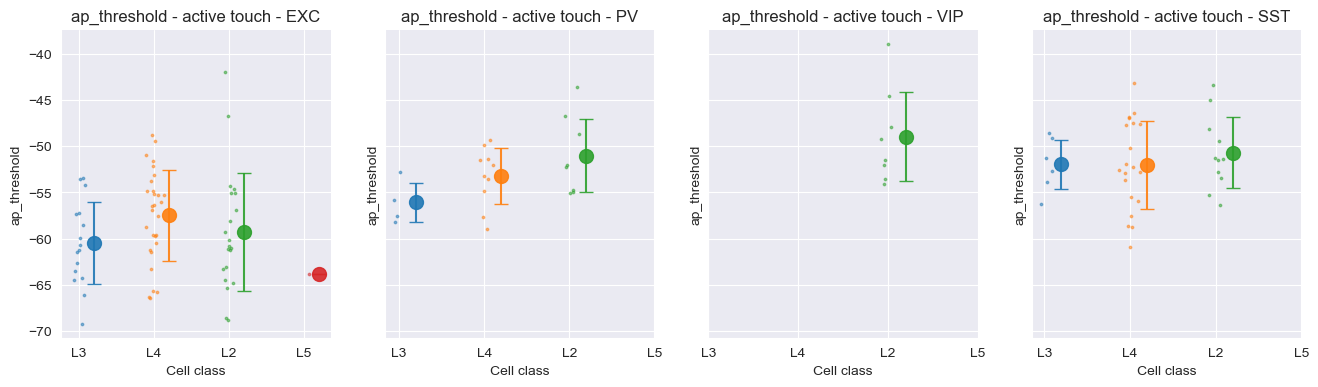

In [73]:
columns = ["mean_vm", "firing_rate","ap_duration", "ap_threshold"]
for col in columns:
    plot1(result_dict_df, col)
    plot2(result_dict_df, col)

In [57]:
layer_color = {'L2':'k',
               'L3':'indianred',
               'L4':'royalblue',
               'L5':'darkorange',
                'L2/3':'darkgreen'}
cell_class_order_layer = ['L2', 'L2/3', 'L3', 'L4','L5']

Text(0.5, 1.0, 'Grand-average FFTs y logscale - all cells')

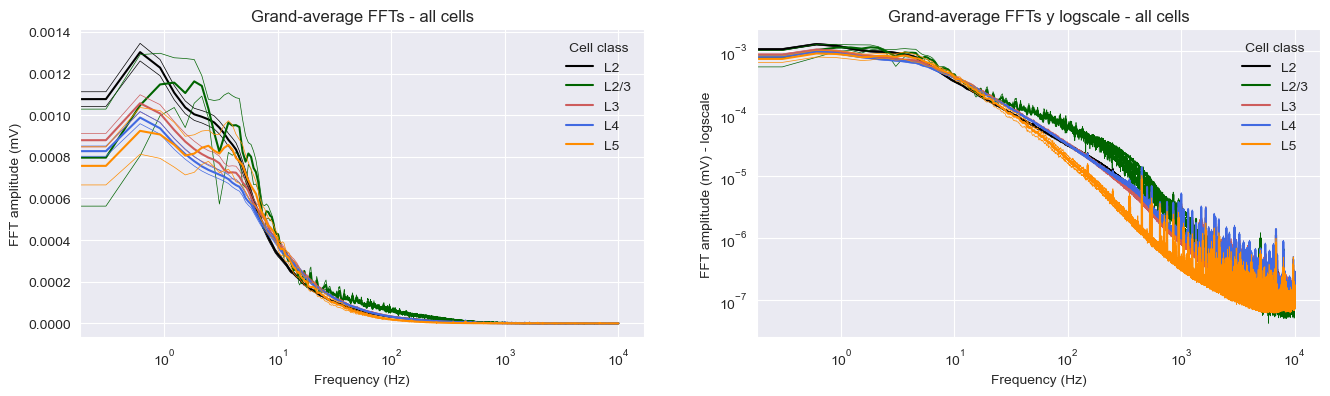

In [59]:
# Define figure
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_layer in enumerate(cell_class_order_layer):

    #Provide as input a matrix (stacked average FFTs)
    fft_matrix = np.stack(result_fft_cell_type[c_layer], axis=1)
    for ax in axs:
        plot_avg_mean_fft(ax, fft_matrix, sr_vm, c_layer, layer_color[c_layer])

for ax in axs:
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('FFT amplitude (mV)')
    ax.set_title('Grand-average FFTs - all cells')
    ax.legend(frameon=False, loc='upper right', title='Cell layer')
axs[1].set_yscale("log")
axs[1].set_ylabel('FFT amplitude (mV) - logscale')
ax.set_title('Grand-average FFTs y logscale - all cells')

Text(0.5, 1.0, 'Grand-average FFTs y logscale - free whisking')

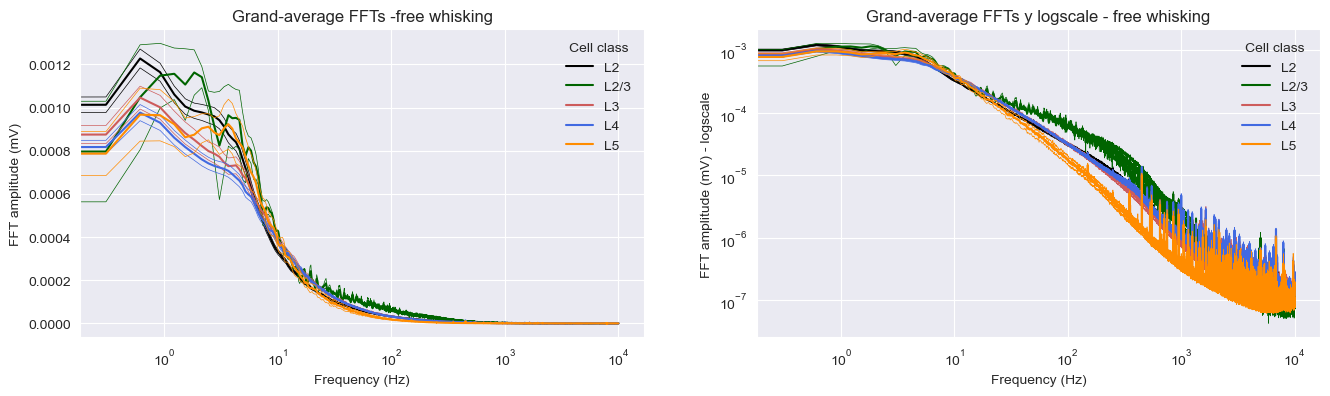

In [62]:
# Define figure
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,4), dpi=100)
remove_top_right_frame(ax)
part_analysed = "free whisking"
# Iterate over cell class
for i, c_layer in enumerate(cell_class_order_layer):

    #Provide as input a matrix (stacked average FFTs)
    fft_matrix = np.stack(result_fft[part_analysed][c_layer], axis=1)
    for ax in axs:
        plot_avg_mean_fft(ax, fft_matrix, sr_vm, c_layer, layer_color[c_layer])

for ax in axs:
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('FFT amplitude (mV)')
    ax.set_title('Grand-average FFTs -%s' %part_analysed)
    ax.legend(frameon=False, loc='upper right', title='Cell layer')
axs[1].set_yscale("log")
axs[1].set_ylabel('FFT amplitude (mV) - logscale')
ax.set_title('Grand-average FFTs y logscale - %s' %part_analysed)

Text(0.5, 1.0, 'Grand-average FFTs y logscale - active touch')

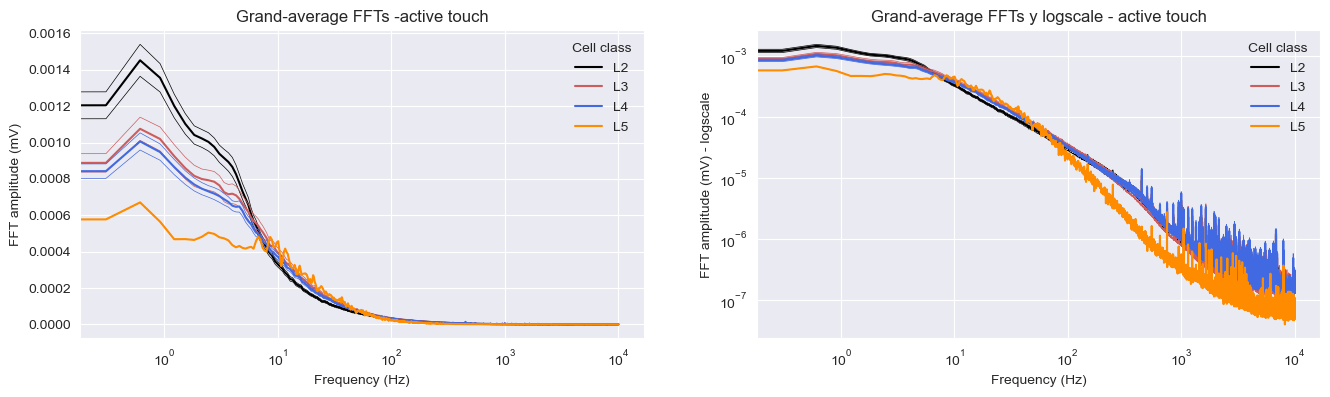

In [69]:
# Define figure
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,4), dpi=100)
remove_top_right_frame(ax)
part_analysed = "active touch"
result_fft[part_analysed].pop("L2/3", None)
# Iterate over cell class
for i, c_layer in enumerate(cell_class_order_layer):
    if c_layer == "L2/3":
        continue
    #Provide as input a matrix (stacked average FFTs)
    fft_matrix = np.stack(result_fft[part_analysed][c_layer], axis=1)
    for ax in axs:
        plot_avg_mean_fft(ax, fft_matrix, sr_vm, c_layer, layer_color[c_layer])

for ax in axs:
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('FFT amplitude (mV)')
    ax.set_title('Grand-average FFTs -%s' %part_analysed)
    ax.legend(frameon=False, loc='upper right', title='Cell layer')
axs[1].set_yscale("log")
axs[1].set_ylabel('FFT amplitude (mV) - logscale')
ax.set_title('Grand-average FFTs y logscale - %s' %part_analysed)

In [102]:
from sklearn.linear_model import LinearRegression
def plot_linreg1(result_dict_df, xlabel, ylabel):
    for key in result_dict_df:
        result_df = result_dict_df[key]
        fig, axs = plt.subplots(1,len(result_df.cell_layer2.unique()), sharey=True, sharex=True, figsize=(16,4), dpi=100)

        for i,layer in enumerate(result_df.cell_layer2.unique()):
            ax = axs[i]
            # Define figure
            remove_top_right_frame(ax)
            # Plot data
            datax = result_df[result_df.cell_layer2 == layer][xlabel].values
            datay = result_df[result_df.cell_layer2 == layer][ylabel].values


            ax.scatter(x=datax,
                       y=datay,
                       s=5,
                       alpha=0.5,
                       c=layer_color[layer],
                       label=layer)

            # Axes
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title('%s \n %s vs. %s - %s' %(layer,xlabel, ylabel, key))


            # Fit linear regression model and plot regression line
            datax_all = datax
            datay_all = datay
            nan_ids = np.isinf(datax_all) + np.isnan(datay_all) #finding NaNs
            X=datax_all[~nan_ids]
            y=datay_all[~nan_ids]
            #
            model = LinearRegression().fit(X.reshape(-1, 1), #must be 2D
                                           y)
            x_range = np.array(plt.xlim())
            y_fit = model.intercept_ + model.coef_[0] * x_range

            result = scipy.stats.linregress(X, y)

            ax.plot(x_range,
                    y_fit,
                    ls='--',
                    linewidth=1,
                    alpha=0.3,
                    color='k',
                    label='fitted line: \n r = {:.2f}, p = {:.5f}'.format(result.rvalue, result.pvalue)
                    )
            ax.legend(frameon=False)

C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


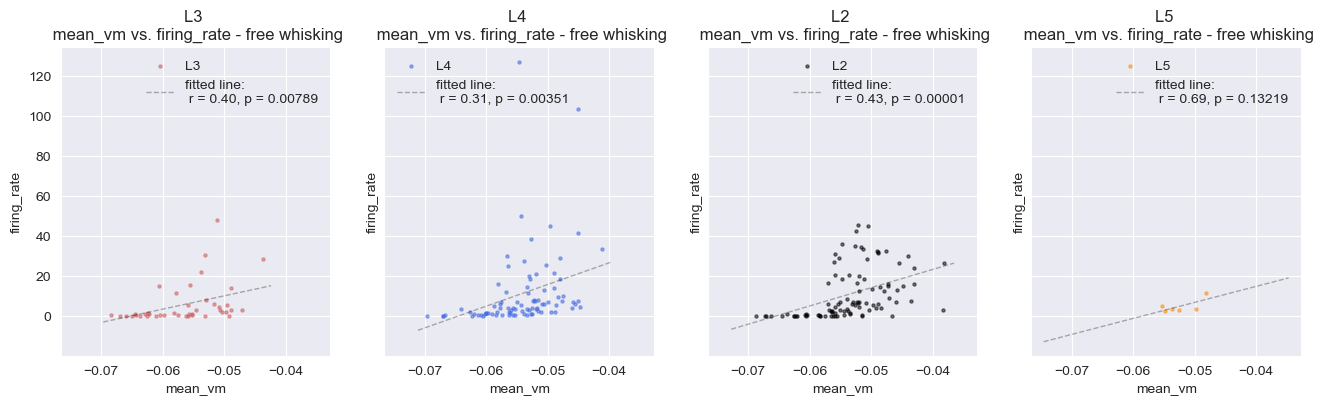

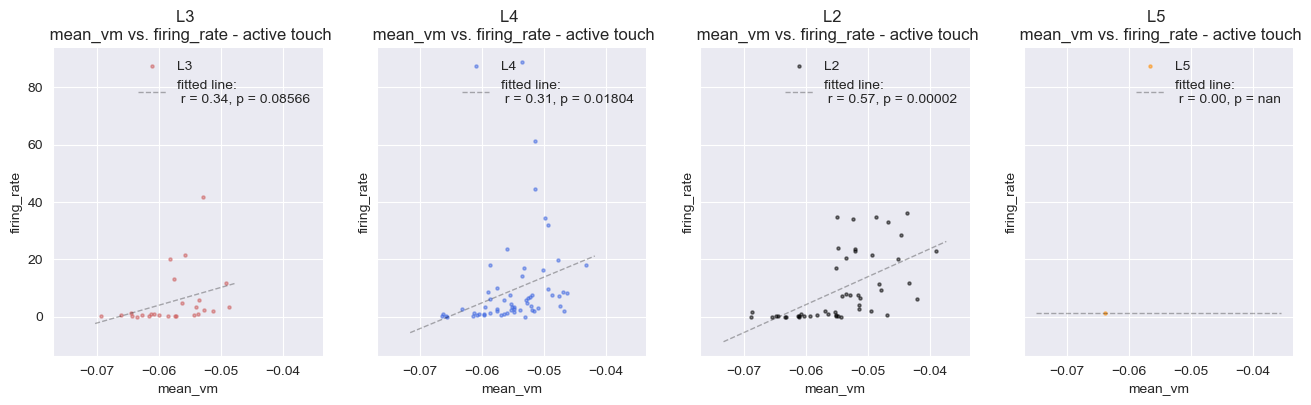

In [103]:
plot_linreg1(result_dict_df, "mean_vm", "firing_rate")

C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\xagao\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:19

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

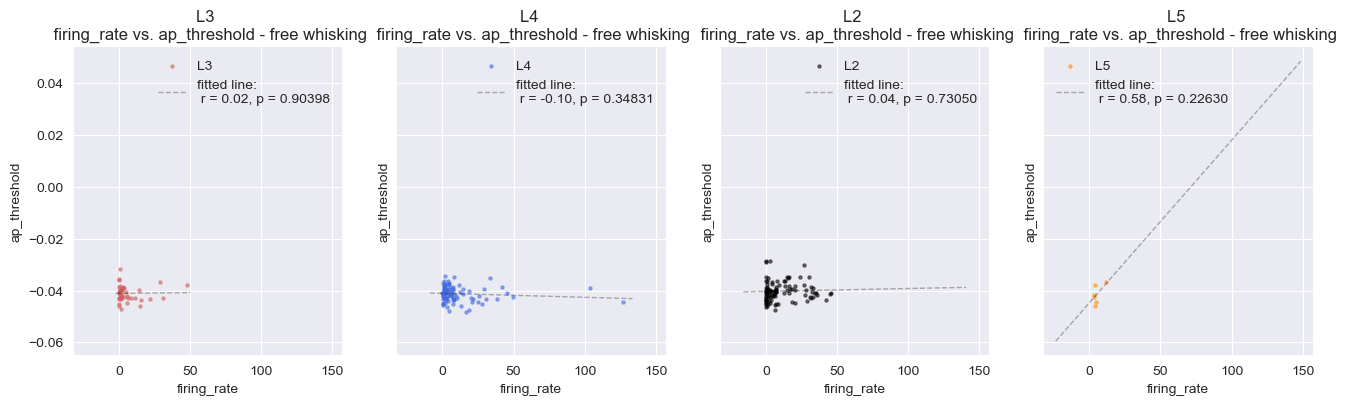

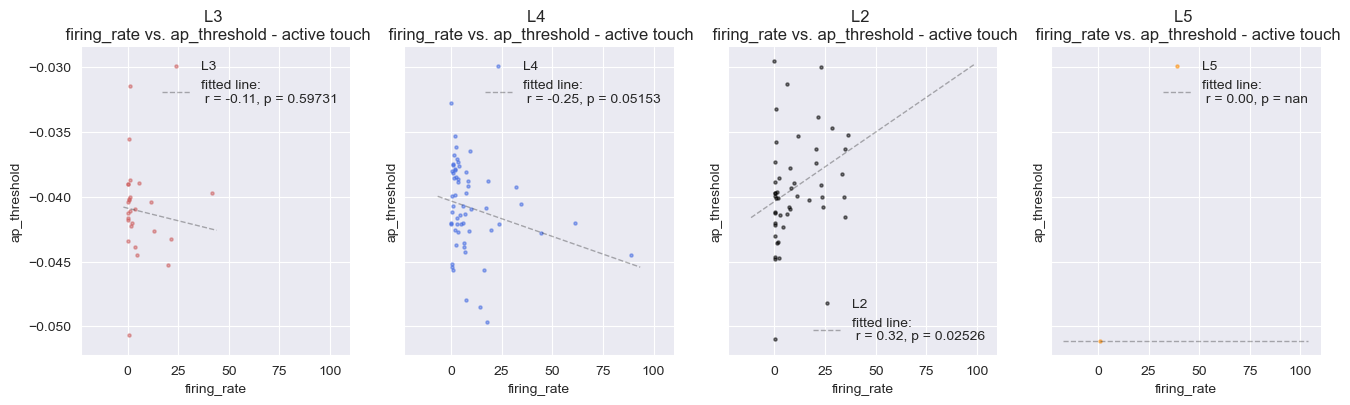

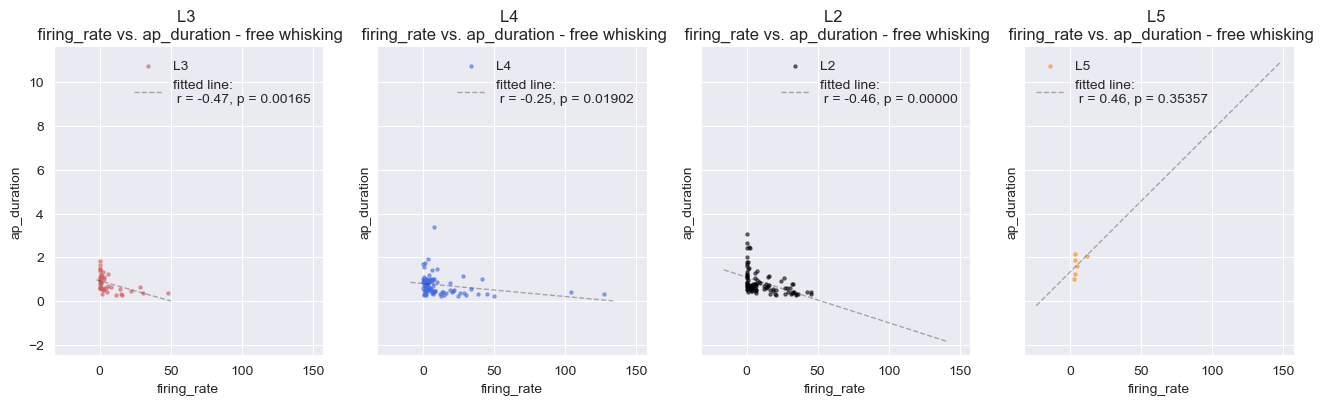

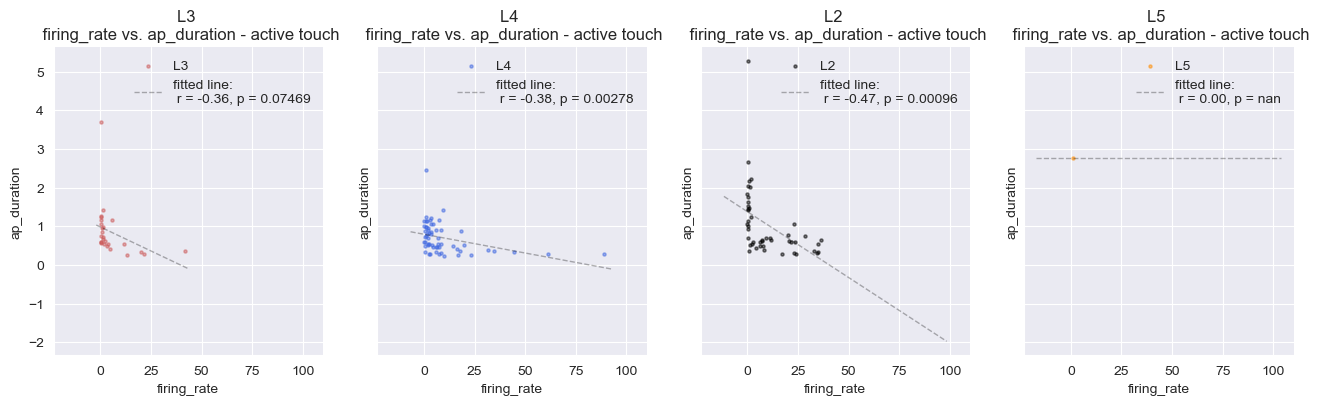

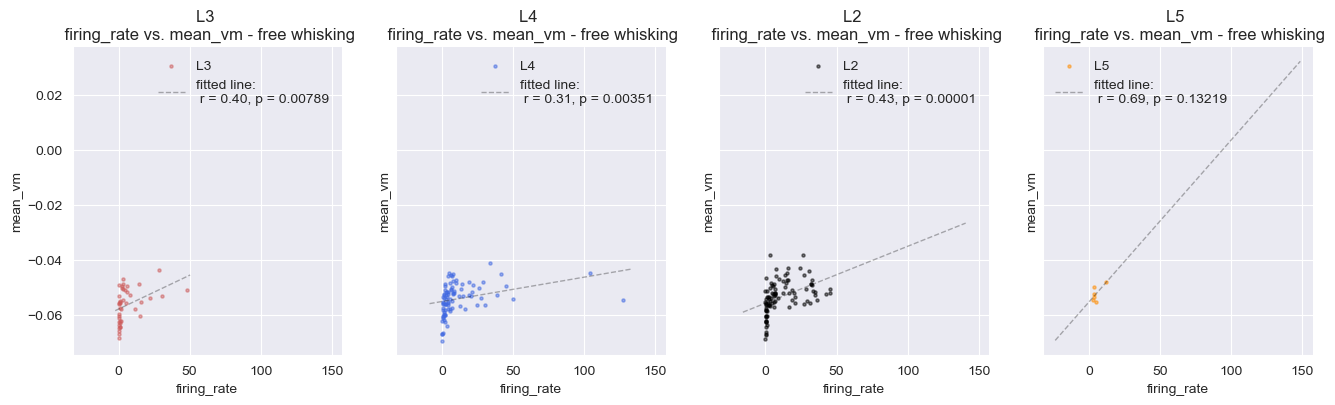

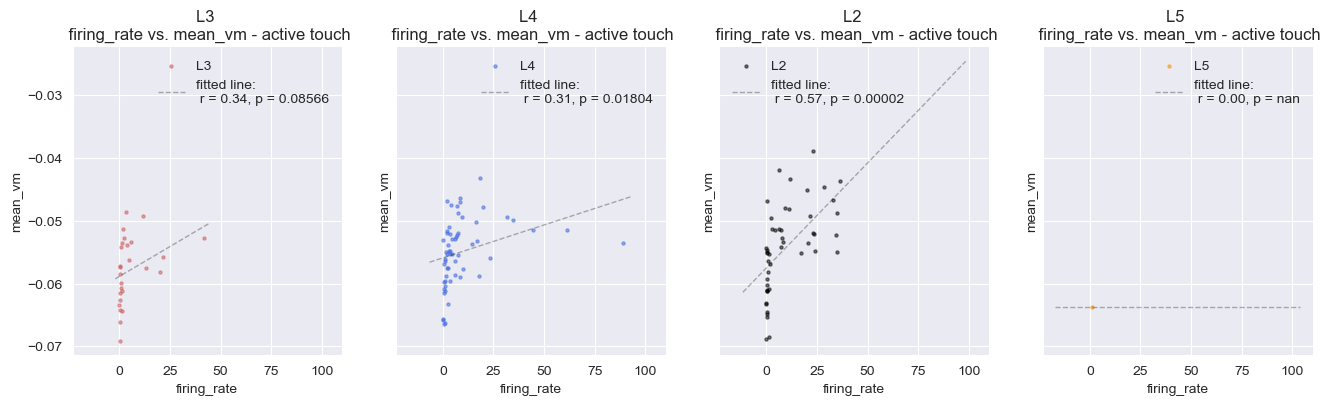

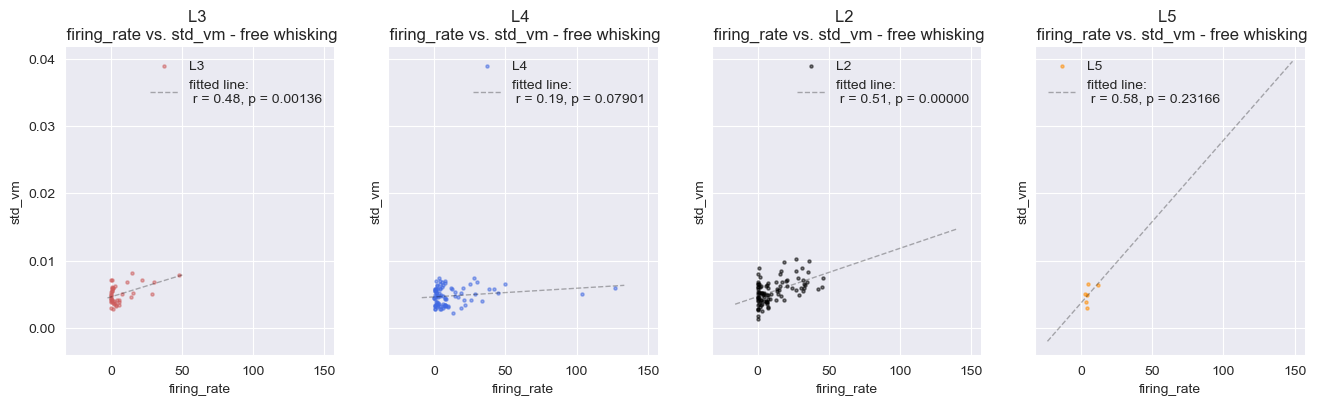

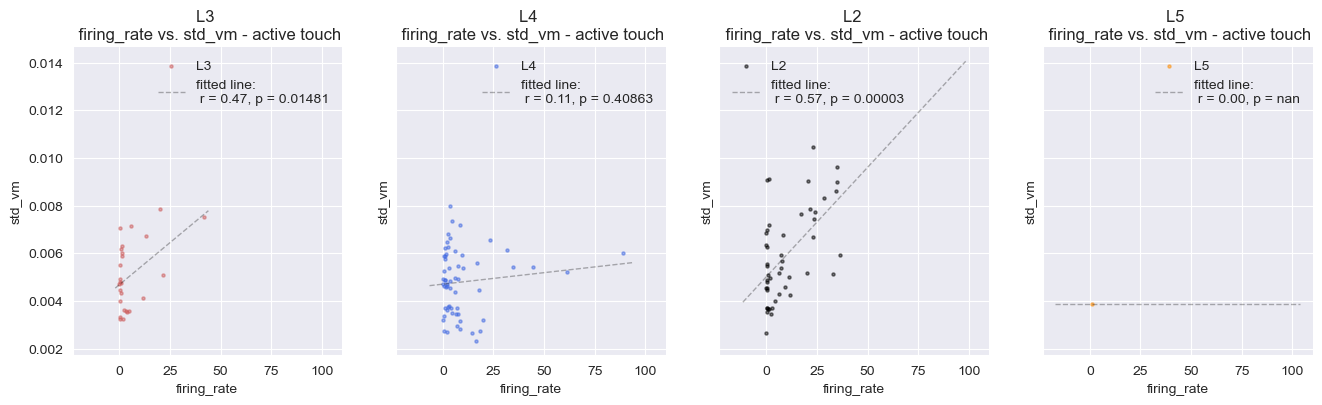

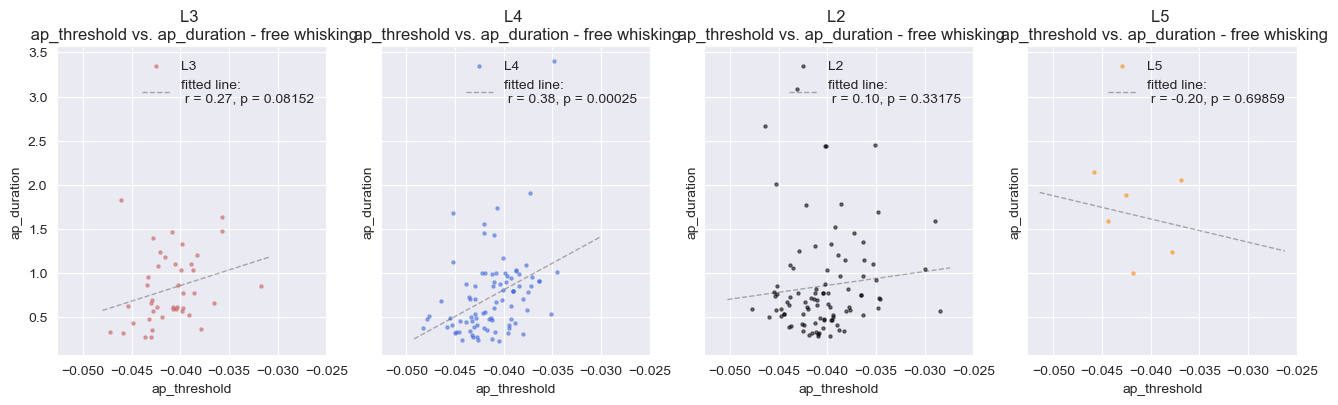

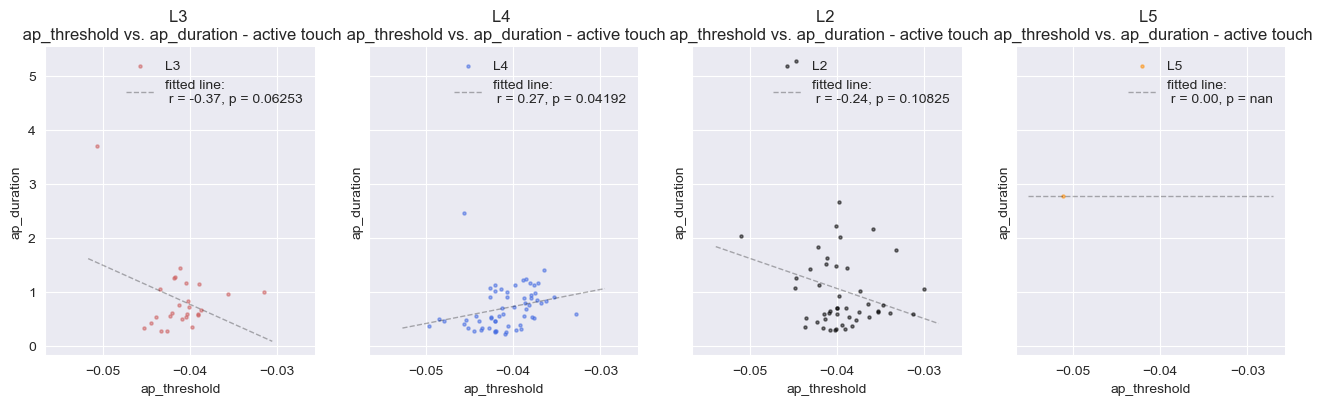

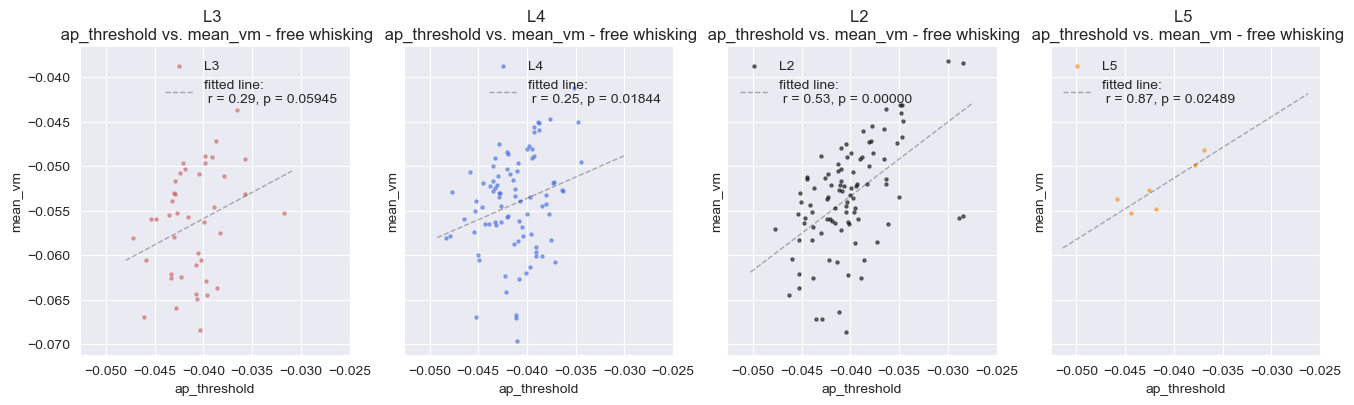

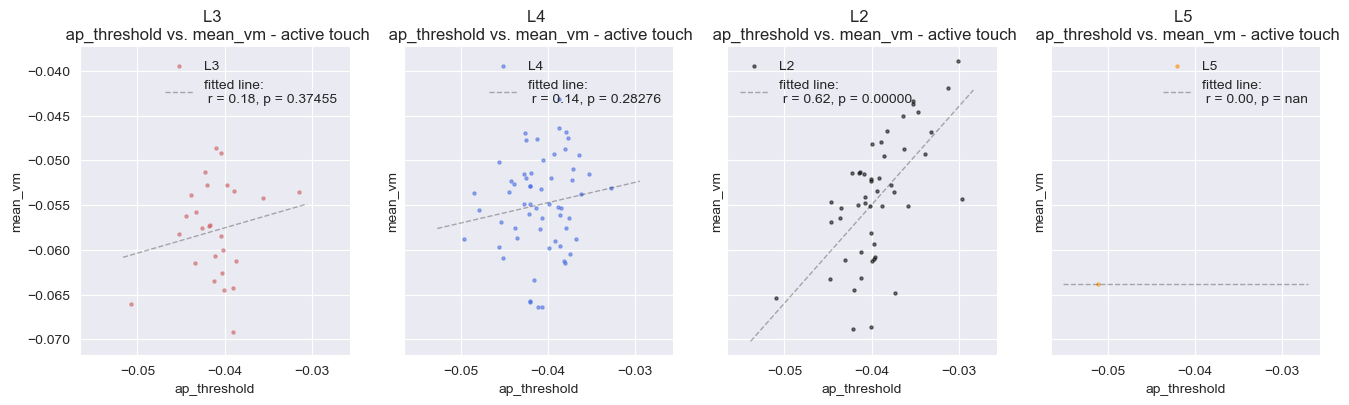

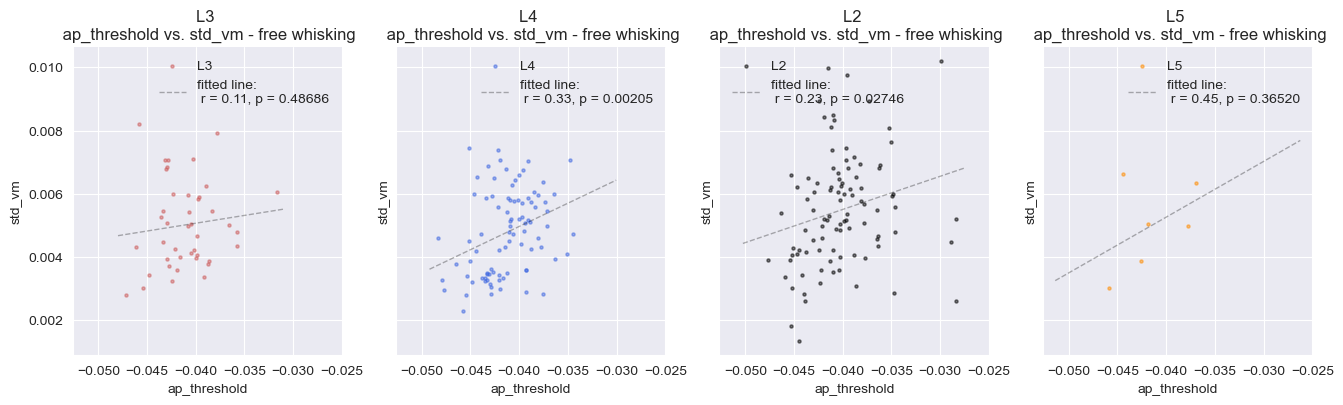

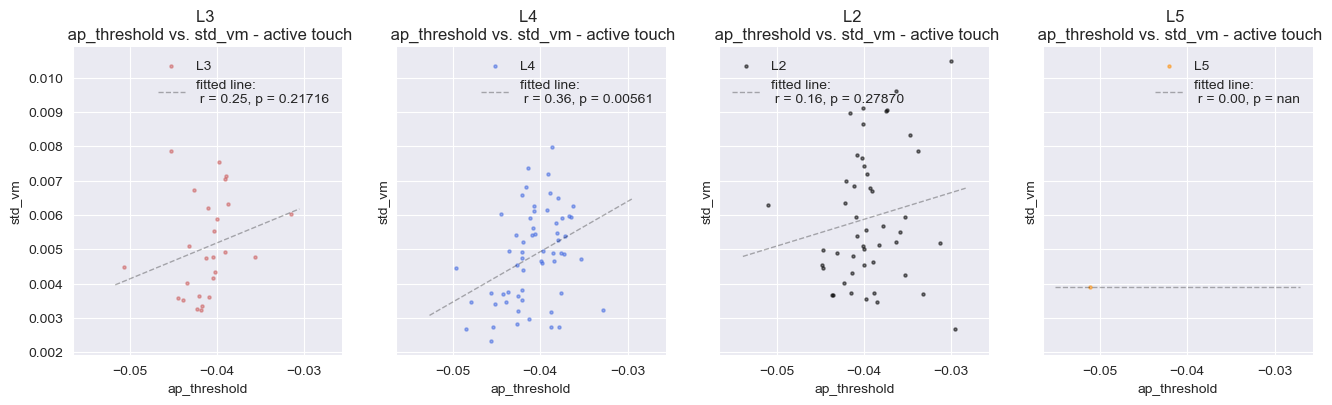

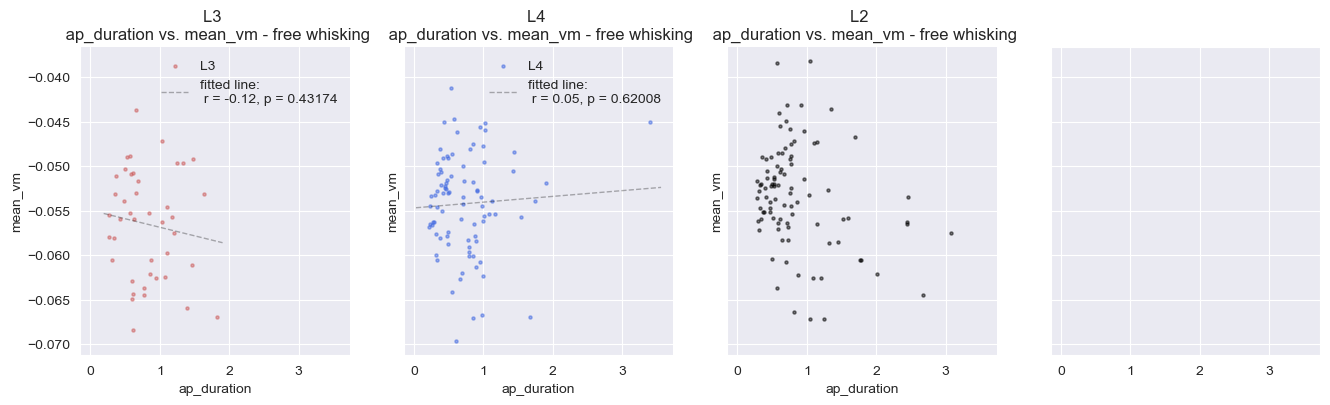

In [106]:
from itertools import combinations

interesting = ["firing_rate", "ap_threshold", "ap_duration", "mean_vm", "std_vm"]
res = list(combinations(interesting, 2))
for label1, label2 in res:
    plot_linreg1(result_dict_df, label1, label2)